# Coastal Kelvin Wave Test Case

simulating a coastal kelvin wave

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS/MPAS_Ocean/"

In [2]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [3]:
function kelvin_test(mesh_directory, base_mesh_file_name, mesh_file_name, periodicity, T; plot=false)
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name, periodicity=periodicity)
        
    meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)
    meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)
    c = sqrt(mpasOcean.gravity*meanFluidThicknessH)
    rossbyRadiusR = c/meanCoriolisParameterf
    
    println("simulating for T: ", T)
    lYedge = maximum(mpasOcean.yEdge) - minimum(mpasOcean.yEdge)
    
#     function lateralProfileGaussian(y)
#         mu = lYedge/2#20.0e5
#         sigma = 3.0e3
#         return 1e-3*exp(- (y .% lyEdge -mu)^2 / sigma^2) #* cos(y*5.0e-6)
#     end

    function lateralProfilePeriodic(y)
        return 1e-3*cos(y/lYedge * 4 * pi)
    end

    lateralProfile = lateralProfilePeriodic
    
    function kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t=0)
        v = sqrt(mpasOcean.gravity*meanFluidThicknessH) * lateralProfile(mpasOcean.yEdge[iEdge] .+ c*t) * exp(-mpasOcean.xEdge[iEdge]/rossbyRadiusR)
        return v*sin(mpasOcean.angleEdge[iEdge])
    end

    function kelvinWaveExactSSH(mpasOcean, iCell, t=0)
        return - meanFluidThicknessH * lateralProfile(mpasOcean.yCell[iCell] .+ c*t) * exp(-mpasOcean.xCell[iCell]/rossbyRadiusR)
    end

    function kelvinWaveExactSolution!(mpasOcean, t=0)
        for iCell in 1:mpasOcean.nCells
            mpasOcean.sshCurrent[iCell] = kelvinWaveExactSSH(mpasOcean, iCell, t)
        end

        for iEdge in 1:mpasOcean.nEdges
            mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
        end
    end

    function boundaryCondition!(mpasOcean, t)
        for iEdge in 1:mpasOcean.nEdges
            if mpasOcean.boundaryEdge[iEdge] == 1.0
                mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
            end
        end

    end
    
    
    kelvinWaveExactSolution!(mpasOcean)
        
    nSaves = 1
    mpasOcean.dt = 0.1 * mpasOcean.dcEdge[1] / c
    saveInterval = round(T/mpasOcean.dt)
    mpasOcean.dt = T / saveInterval
    
    sshOverTimeNumerical = zeros(Float64, (nSaves, mpasOcean.nCells))
    sshOverTimeExact = zeros(Float64, (nSaves, mpasOcean.nCells))
    
    println("dx ", mpasOcean.dcEdge[1])
    println("dt ", mpasOcean.dt)
    
    t = 0
    for i in 1:nSaves
        for j in 1:saveInterval

            calculate_normal_velocity_tendency!(mpasOcean)
            update_normal_velocity_by_tendency!(mpasOcean)

            boundaryCondition!(mpasOcean, t)

            calculate_ssh_tendency!(mpasOcean)
            update_ssh_by_tendency!(mpasOcean)

            t += mpasOcean.dt
        end
        sshOverTimeNumerical[i,:] .= mpasOcean.sshCurrent[:]
    end
    
    if plot
        fig, ax, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
        fig.suptitle("numerical solution")
        display(fig)
    end
    
    t = 0
    for iCell = 1:mpasOcean.nCells
        sshOverTimeExact[1,iCell] = kelvinWaveExactSSH(mpasOcean, iCell, T)
    end
    
    if plot
        fig, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:])
        fig.suptitle("exact solution")
        display(fig)
        
        fig, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:] - sshOverTimeNumerical[end,:])
        fig.suptitle("difference")
        display(fig)
    end
    
    error = sshOverTimeNumerical .- sshOverTimeExact
    MaxErrorNorm = norm(error, Inf)
    L2ErrorNorm = norm(error/sqrt(float(mpasOcean.nCells)))
    
    return mpasOcean.gridSpacingMagnitude, MaxErrorNorm, L2ErrorNorm
end

kelvin_test (generic function with 1 method)

simulating for T: 20000
dx 

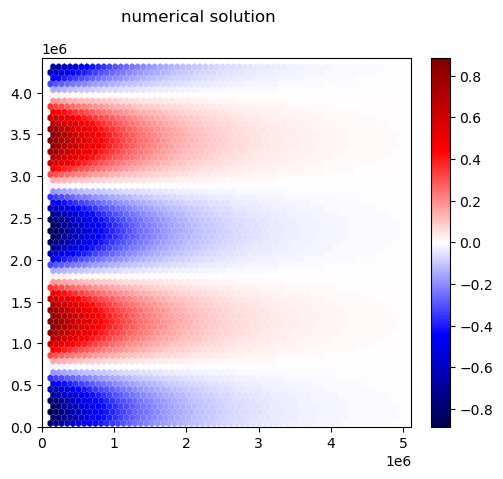

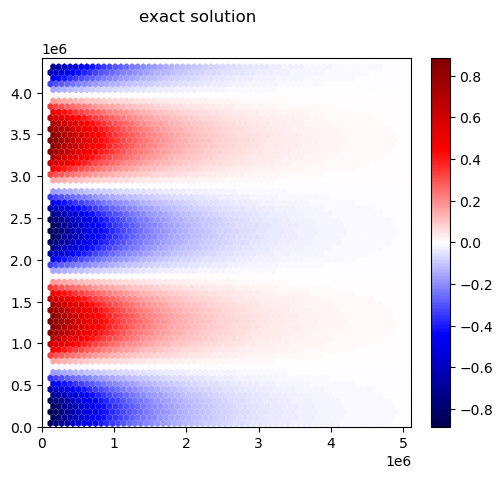

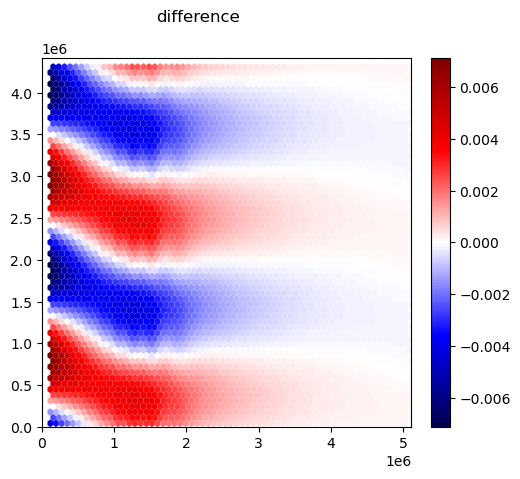

78124.99999999921
dt 79.05138339920948


(78125.00000000023, 0.007141428993815202, 0.001905924480879383)

In [4]:
T = 20000
nCellsX = 64
kelvin_test(
    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
    "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", "NonPeriodic_x", T, plot=true)

In [5]:
function convergence_test(periodicity, mesh_directory, operator_name, test)
    nCellsXMin = 100
    nCellsXMax = 150
    d_nCellsX = 10
    nCases = Int((nCellsXMax - nCellsXMin)/d_nCellsX) + 1
    nCellsX = collect(Int.(round.(range(nCellsXMin,nCellsXMax,length=nCases))))
    dc = zeros(Float64, nCases)
    MaxErrorNorm = zeros(Float64, nCases)
    L2ErrorNorm = zeros(Float64, nCases)
    
    T = 20000
    
    for iCase = 1:nCases
        if periodicity == "Periodic"
            base_mesh_file_name = "base_mesh_$(nCellsX[iCase]).nc"
        else
            base_mesh_file_name = "culled_mesh_$(nCellsX[iCase]).nc"
        end
        mesh_file_name = "mesh_$(nCellsX[iCase]).nc"
        println("running test $iCase of $nCases")
        dc[iCase], MaxErrorNorm[iCase], L2ErrorNorm[iCase] =
                test(mesh_directory, base_mesh_file_name, mesh_file_name, periodicity, T;
                        plot=false)
    end
    
    A = [log10.(dc)    ones(length(dc))]
    m, c = A \ log10.(MaxErrorNorm)
    y = m*log10.(dc) .+ c
    y = 10 .^ y
    
    fig, ax = subplots(1,1)
    loglog(dc, MaxErrorNorm, label="Maximum Error Norm", marker="s")
    loglog(dc, y, label="Best Fit Line, slope=$m")
    ax.set_title("Convergence Plot of Maximum Error Norm of $operator_name")
    ax.legend()
    ax.set_xlabel("Grid cell size")
    ax.set_ylabel("Maximum Error Norm of $operator_name")
    grid(which="both")
    
    
    A = [log10.(dc)    ones(length(dc))]
    m, c = A \ log10.(L2ErrorNorm)
    y = m*log10.(dc) .+ c
    y = 10 .^ y
    
    fig, ax = subplots(1,1)
    loglog(dc, L2ErrorNorm, label="L2 Error Norm", marker="s")
    loglog(dc, y, label="Best Fit Line, slope=$m")
    ax.set_title("Convergence Plot of L2 Error Norm of $operator_name")
    ax.legend()
    ax.set_xlabel("Grid cell size")
    ax.set_ylabel("L2 Error Norm of $operator_name")
    grid(which="both")
end

convergence_test (generic function with 1 method)

running test 1 of 6
simulating for T: 20000
lY 4.373428289111415e6 4.330127018922193e6
c 98.99494936611666
dx/dt 990.0
running test 2 of 6
simulating for T: 20000
lY 4.369492203651215e6 4.330127018965494e6
c 98.99494936611666
dx/dt 990.9090909189816
running test 3 of 6
simulating for T: 20000
lY 4.36621169942168e6 4.3301270189568335e6
c 98.99494936611666
dx/dt 989.5833333412673
running test 4 of 6
simulating for T: 20000
lY 4.36343608800255e6 4.330127018974154e6
c 98.99494936611666
dx/dt 990.3846153965143
running test 5 of 6
simulating for T: 20000
lY 4.3610562501929505e6 4.3301270188875515e6
c 98.99494936611666
dx/dt 989.285714277787
running test 6 of 6


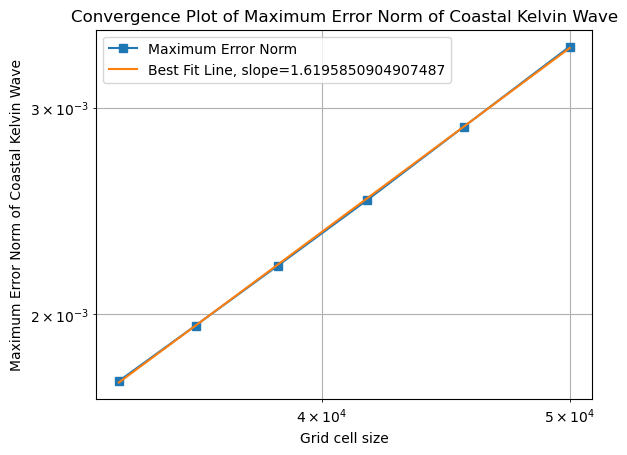

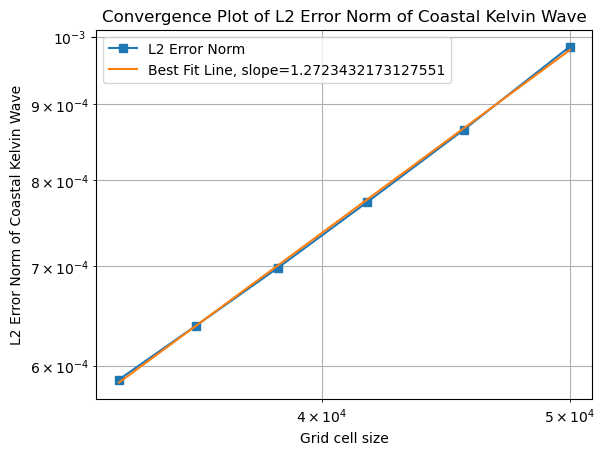

simulating for T: 20000
lY 4.358994243706539e6 4.330127018878892e6
c 98.99494936611666
dx/dt 989.9999999901198


In [132]:
convergence_test("NonPeriodic_x",
            CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
            "Coastal Kelvin Wave",
            kelvin_test)

# GPU version

In [6]:
import CUDA

In [18]:
function boundaryConditionCUDAKernel!(nEdges, boundaryEdge, gravity, H, lateralProfile,
                                        yEdge, lYedge, xEdge, R, normalVelocityCurrent,
                                        angleEdge, t)
    iEdge = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
    if iEdge <= nEdges
        if boundaryEdge[iEdge] == 1
            c = CUDA.sqrt(gravity * H)
            v = c * lateralProfile(yEdge[iEdge] .+ c*t, lYedge) * CUDA.exp(-xEdge[iEdge]/R)
            normalVelocityCurrent[iEdge] = v*CUDA.sin(angleEdge[iEdge])
        end
    end

    return
end

boundaryConditionCUDAKernel! (generic function with 1 method)

In [21]:
function kelvin_test_cuda(mesh_directory, base_mesh_file_name, mesh_file_name, periodicity, T; plot=false)
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name, periodicity=periodicity)
        
    meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)
    meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)
    c = sqrt(mpasOcean.gravity*meanFluidThicknessH)
    rossbyRadiusR = c/meanCoriolisParameterf
    
    println("simulating for T: ", T)
    lYedge = maximum(mpasOcean.yEdge) - minimum(mpasOcean.yEdge)
    

    function lateralProfilePeriodicCUDA(y, lYedge)
        return 1e-3*CUDA.cos(y/lYedge * 4 * CUDA.pi)
    end
    
    function kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t=0)
        v = sqrt(mpasOcean.gravity*meanFluidThicknessH) * lateralProfilePeriodicCUDA(mpasOcean.yEdge[iEdge] .+ c*t, lYedge) * exp(-mpasOcean.xEdge[iEdge]/rossbyRadiusR)
        return v*sin(mpasOcean.angleEdge[iEdge])
    end

    function kelvinWaveExactSSH(mpasOcean, iCell, t=0)
        return - meanFluidThicknessH * lateralProfilePeriodicCUDA(mpasOcean.yCell[iCell] .+ c*t, lYedge) * exp(-mpasOcean.xCell[iCell]/rossbyRadiusR)
    end

    function kelvinWaveExactSolution!(mpasOcean, t=0)
        for iCell in 1:mpasOcean.nCells
            mpasOcean.sshCurrent[iCell] = kelvinWaveExactSSH(mpasOcean, iCell, t)
        end

        for iEdge in 1:mpasOcean.nEdges
            mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
        end
    end

    function boundaryConditionCUDA!(mpasOcean, t)
        CUDA.@cuda blocks=cld(mpasOcean.nEdges, 1024) threads=1024 maxregs=64 boundaryConditionCUDAKernel!(
            mpasOcean.nEdges, mpasOcean.boundaryEdge, mpasOcean.gravity, meanFluidThicknessH, lateralProfilePeriodicCUDA,
            mpasOcean.yEdge, lYedge, mpasOcean.xEdge, rossbyRadiusR, mpasOcean.normalVelocityCurrent, 
            mpasOcean.angleEdge, t
        )
    end
    
    moveArrays!(mpasOcean, Array)
    kelvinWaveExactSolution!(mpasOcean)
        
    nSaves = 1
    mpasOcean.dt = 0.1 * mpasOcean.dcEdge[1] / c
    saveInterval = round(T/mpasOcean.dt)
    mpasOcean.dt = T / saveInterval
    
    sshOverTimeNumerical = zeros(Float64, (nSaves, mpasOcean.nCells))
    sshOverTimeExact = zeros(Float64, (nSaves, mpasOcean.nCells))
    
    println("dx ", mpasOcean.dcEdge[1])
    println("dt ", mpasOcean.dt)
    
    moveArrays!(mpasOcean, CUDA.CuArray)
    t = 0
    for i in 1:nSaves
        for j in 1:saveInterval

            calculate_normal_velocity_tendency_cuda!(mpasOcean)
            update_normal_velocity_by_tendency_cuda!(mpasOcean)

            boundaryConditionCUDA!(mpasOcean, t)

            calculate_ssh_tendency_cuda!(mpasOcean)
            update_ssh_by_tendency_cuda!(mpasOcean)

            t += mpasOcean.dt
        end
        sshOverTimeNumerical[i,:] .= mpasOcean.sshCurrent[:]
    end
    
    moveArrays!(mpasOcean, Array)
    if plot
        fig, ax, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
        fig.suptitle("numerical solution")
        display(fig)
    end
    
    t = 0
    for iCell = 1:mpasOcean.nCells
        sshOverTimeExact[1,iCell] = kelvinWaveExactSSH(mpasOcean, iCell, T)
    end
    
    if plot
        fig, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:])
        fig.suptitle("exact solution")
        display(fig)
        
        fig, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:] - sshOverTimeNumerical[end,:])
        fig.suptitle("difference")
        display(fig)
    end
    
    error = sshOverTimeNumerical .- sshOverTimeExact
    MaxErrorNorm = norm(error, Inf)
    L2ErrorNorm = norm(error/sqrt(float(mpasOcean.nCells)))
    
    return mpasOcean.gridSpacingMagnitude, MaxErrorNorm, L2ErrorNorm
end

kelvin_test_cuda (generic function with 1 method)

simulating for T: 20000
dx 78124.99999999921
dt 79.05138339920948


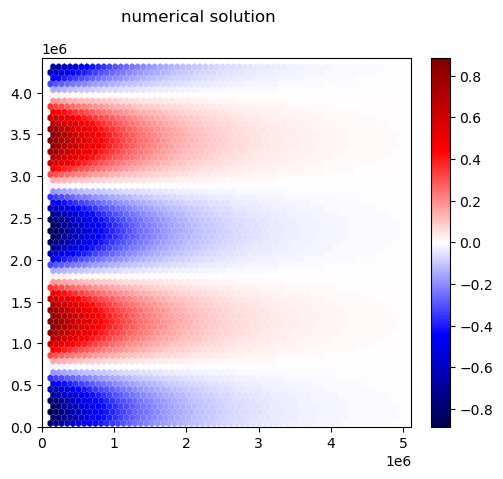

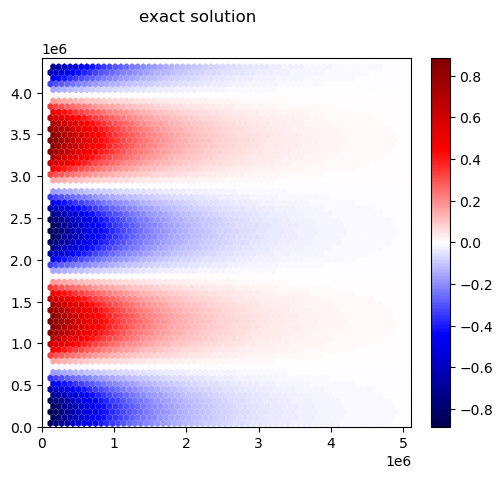

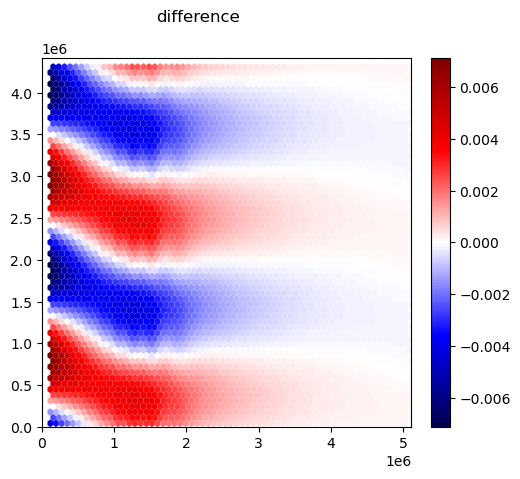

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007ff72387df90.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/rrs/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


(78125.00000000023, 0.007141428993815424, 0.001905924480879386)

In [20]:
T = 20000
nCellsX = 64
kelvin_test_cuda(
    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
    "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", "NonPeriodic_x", T, plot=true)

running test 1 of 6
simulating for T: 20000
dx 50000.0
dt 50.505050505050505
running test 2 of 6
simulating for T: 20000
dx 45454.545454999155
dt 45.87155963302752
running test 3 of 6
simulating for T: 20000
dx 41666.66666700073
dt 42.10526315789474
running test 4 of 6
simulating for T: 20000
dx 38461.53846200055
dt 38.83495145631068
running test 5 of 6
simulating for T: 20000
dx 35714.28571399953
dt 36.101083032490976
running test 6 of 6
simulating for T: 20000
dx 33333.333333000664
dt 33.67003367003367


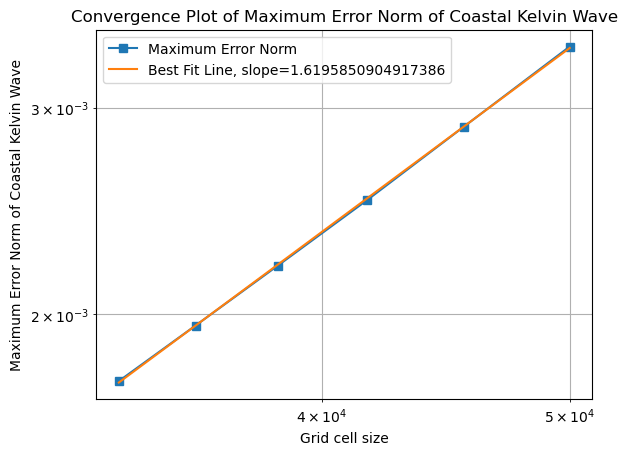

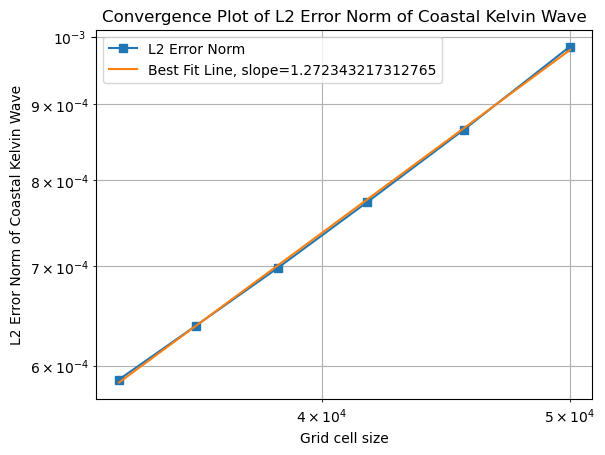

In [22]:
convergence_test("NonPeriodic_x",
            CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
            "Coastal Kelvin Wave",
            kelvin_test_cuda)